In [1]:
import math
import numpy as np
import pandas as pd
import torch
import torch.autograd as autograd
import torch.optim as optim
import matplotlib.pyplot as plt
device = torch.device(3 if torch.cuda.is_available() else 'cpu')
import time

In [2]:
import time
import seaborn as sns

In [3]:
import torch.distributions as D
K = 10
torch.manual_seed(1)
mix = D.Categorical(torch.ones(K,).to(device))
comp = D.Independent(D.Normal(
             torch.randn(K,2).to(device), torch.ones(K,2).to(device)*0.1), 1)
gmm = D.MixtureSameFamily(mix, comp)

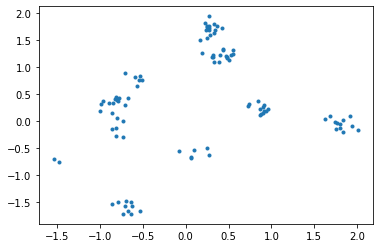

In [4]:
sample = gmm.sample((100,)).cpu()
plt.plot(sample[:,0],sample[:,1],'.')

In [5]:
def divergence_bf(dx, y):
    sum_diag = 0.
    for i in range(y.shape[1]):
        sum_diag += torch.autograd.grad(dx[:, i].sum(), y, create_graph=True)[0].contiguous()[:, i].contiguous()
    return sum_diag.contiguous()

def sample_rademacher_like(y):
    return torch.randint(low=0, high=2, size=y.shape).to(y) * 2 - 1


def sample_gaussian_like(y):
    return torch.randn_like(y)

def divergence_approx(f, y, e=None):
    if e is None:
        e = sample_rademacher_like(y)
    e_dzdx = torch.autograd.grad(f, y, e, create_graph=True)[0]
    e_dzdx_e = e_dzdx * e
    approx_tr_dzdx = e_dzdx_e.view(y.shape[0], -1).sum(dim=1)
    return approx_tr_dzdx





    

    
class PFGfast:
  def __init__(self, P, net, optimizer1,optimizer2):
    self.P = P
    self.net = net
    self.optim1 = optimizer1
    self.optim2 = optimizer2

  def phi(self, X):
    #self.net.eval()
    #X = X.detach().requires_grad_(True)
    
    #log_prob = self.P.log_prob(X)
    #score_func = torch.autograd.grad(log_prob.sum(), X)[0]
    
    phi = self.net(X) / X.size(0)

    return -phi

  def step(self, X):
    self.optim1.zero_grad()
    X.grad = self.phi(X)
    self.optim1.step()

  def score_step(self, X):
    H = torch.std(X,0)
    X = X.detach().requires_grad_(True)
    
    log_prob = self.P.log_prob(X)
    score_func = torch.autograd.grad(log_prob.sum(), X)[0].detach()
    
    self.net.train()
    
    X = X.detach().requires_grad_(True)
    S = self.net(X)


    H = torch.eye(X.shape[1])

    self.optim2.zero_grad()
    
    loss = (-torch.sum(score_func*S) - torch.sum(divergence_approx(S,X)) + 0.5*torch.trace(H.matmul(S.T).matmul(S)))/S.shape[0]
    loss.backward()
    self.optim2.step()

In [6]:
from torch import nn

n = 1000
X_init = (torch.randn(n, 2)).to(device)




X = X_init.clone()

h = 32
net = nn.Sequential(nn.Linear(2,h),nn.Tanh(),nn.Linear(h,h),nn.Tanh(),nn.Linear(h,2)).to(device)

s = lambda x: net(x)

In [7]:
pfg = PFGfast(gmm, net,optim.SGD([X], lr=1e-1,momentum=0.),optim.SGD(net.parameters(), lr=1e-3, momentum=0.9,nesterov=1))


#optim.SGD(net.parameters(), lr=1e-2,momentum=0.)
t1 = time.time()

for i in range(100):
    pfg.score_step(X)

for i in range(2000):
    
    for j in range(5):
        pfg.score_step(X)
     

    pfg.step(X)
print(time.time()-t1)

27.0117449760437


(-2.0, 2.0)

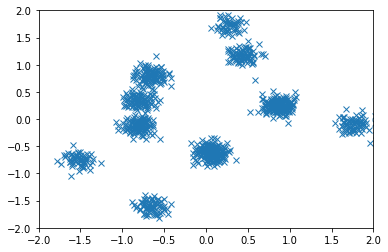

In [8]:
plt.plot(X.cpu().numpy()[:,0],X.cpu().numpy()[:,1],'x')
plt.xlim([-2,2])
plt.ylim([-2,2])

In [9]:
class RBF(torch.nn.Module):
  def __init__(self, sigma=None):
    super(RBF, self).__init__()

    self.sigma = sigma

  def forward(self, X, Y):
    XX = X.matmul(X.t())
    XY = X.matmul(Y.t())
    YY = Y.matmul(Y.t())

    dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

    # Apply the median heuristic (PyTorch does not give true median)
    if self.sigma is None:
        np_dnorm2 = dnorm2.detach()
        h = torch.median(np_dnorm2)/(2 * np.log(X.size(0) + 1))
        sigma = torch.sqrt(h).item()
    else:
        sigma = self.sigma

    gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
    K_XY = (-gamma * dnorm2).exp()

    return K_XY

  def dK(self, X, Y):
    XX = X.matmul(X.t())
    XY = X.matmul(Y.t())
    YY = Y.matmul(Y.t())

    dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

    # Apply the median heuristic (PyTorch does not give true median)
    if self.sigma is None:
        np_dnorm2 = dnorm2.detach()
        h = torch.median(np_dnorm2)/(2 * np.log(X.size(0) + 1))
        sigma = torch.sqrt(h).item()
    else:
        sigma = self.sigma

    gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
    K_XY = (-gamma * dnorm2).exp() #bX x bY
    
    X_Y = X.view(X.shape[0],1,X.shape[1])-Y.view(1,Y.shape[0],Y.shape[1]) # bX x bY x d
    #print(X_Y.shape,K_XY.shape)
    dKXY = torch.sum(K_XY.view(K_XY.shape[0],K_XY.shape[1],1) * (-gamma) * X_Y,0)
    return dKXY
  
# Let us initialize a reusable instance right away.
Ker = RBF()

In [10]:
class SVGD:
  def __init__(self, P, K, optimizer):
    self.P = P
    self.K = K
    self.optim = optimizer

  def phi(self, X):
    X = X.detach().requires_grad_(True)

    log_prob = self.P.log_prob(X)
    score_func = autograd.grad(log_prob.sum(), X)[0]

    K_XX = self.K(X, X.detach())
    grad_K = self.K.dK(X.detach(), X)
    #-autograd.grad(K_XX.sum(), X)[0]

    phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)

    return phi

  def step(self, X):
    self.optim.zero_grad()
    X.grad = -self.phi(X)
    self.optim.step()

In [11]:
X = X_init.clone()
svgd = SVGD(gmm, Ker, optim.SGD([X], lr=1e-2,momentum=0.))
t1 = time.time()
for i in range(2000):
    #print(i)
    svgd.step(X)
    
print(time.time()-t1)

61.38095188140869


(-2.0, 2.0)

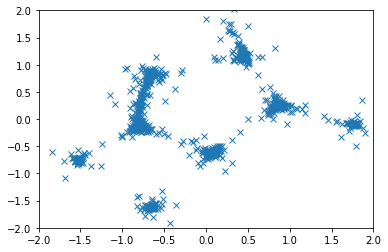

In [12]:
plt.plot(X.cpu().numpy()[:,0],X.cpu().numpy()[:,1],'x')
plt.xlim([-2,2])
plt.ylim([-2,2])